# CMSC 320 Final Project – Checkpoint 2 (Exploratory Data Analysis)

### Information from Checkpoint 1:

#### Group Members:
 * Shreenidhi Ayinala
 * Vasu Mittal
 * Evan Solomon

##### Group Github Repo:
https://github.com/ShreenidhiAyinala/CMSC320_FinalProject

We will be exploring the Planetterp Reviews Data. This data is a collection of numerical ratings
and unstructured text regarding students’ experiences in courses at UMD, College Park.
Source domain: https://planetterp.com/

The reviews pages are not a part of the public API, so we scraped the data programmatically
from the reviews pages for all the courses on the site.
An example of a reviews page for the course CMSC420 is available at:
https://planetterp.com/course/CMSC420/reviews

##### Features of the data:
Each record is of a review left by a student, and it contains the following information/features:
- Date that the review was made
- Course Department and Number (e.g. CMSC320)
- Star rating out of 5 stars (i.e. a ‘top’ rating would be 5 stars, and the lowest rating is 1
star)
- Professor name
- Grade that the student received or is expecting to receive
- Review text – unstructured text that the reviewer can use to supplement their review

##### Size of the Data:
There are approximately 23,000 records that we collected. To the best of our knowledge, this
represents the totality of all the reviews at Planetterp.com

# Exploratory Data Analysis:

## Questions about the data that we explore:
1. Is there a difference in the distribution of the ratings students give courses, between the groups of students who expect to receive an A, and those who expect to recieve a lower grade?
2. Is there a significant difference in mean GPA across different levels of CS courses and different years?
3. Is there a difference between the mean number of stars between anonymous versus non-anonymous users?

In [27]:
# import packages
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import re
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [28]:
course_reviews_data = pd.read_csv("2024_02_21_all_reviews", index_col=0)
df = pd.DataFrame(course_reviews_data)

#### Peek at the data

In [29]:
df.head()

,course_code,status_code,star_count,prof_name,prof_slug,grade,reviewer_name,date,review_text,review_id
0,NFSC112,200,4,Abani Pradhan,/professor/pradhan,Expecting an A,Anonymous,12/23/2023,"Didn't learn anything, but didn't need to. Eas...",review-31256
1,NFSC112,200,5,Qin Wang,/professor/wang_qin,Expecting an A,Anonymous,12/18/2023,Easy class. The lectures are asynchronous but ...,review-30485
2,NFSC112,200,5,Xiaoxue Jia,/professor/jia_xiaoxue,Expecting an A,Anonymous,12/13/2023,She is amazing with ADS and helpful with answe...,review-29852
3,NFSC112,200,2,Abani Pradhan,/professor/pradhan,Expecting a B-,Anonymous,12/06/2023,Easy class as long as you actually watch the l...,review-28855
4,NFSC112,200,5,Qin Wang,/professor/wang_qin,Expecting an A,Anonymous,11/26/2023,"she is a good lecturer, nfsc 112, is ""chill,"" ...",review-28192


#### Preprocessing

In [30]:
# extract dept and course_num using a regular expression
df[['dept', 'course_num']] = df['course_code'].str.extract('([A-Z]{4})([0-9]+[A-Z]*)', expand=True)

# rename grade => expected_grade
df = df.rename(columns={"grade": "expected_grade"})

# convert date => datetime, and add month, year cols
df['date'] = pd.to_datetime(df['date'])
df['month'] = df.date.dt.to_period('M')

def date_to_year_finder(date):
  return date.year

new_year_df = df['date'].apply(date_to_year_finder)
df['year'] = new_year_df

# drop status_code, prof_slug, review_id, and course_code
df = df.loc[:, ~df.columns.isin(['status_code', 'prof_slug','review_id'])]

# convert star_count to numeric
df['star_count'] = pd.to_numeric(df['star_count'])

# dropping duplicates
df.drop_duplicates(inplace=True)

In [31]:
# clean up expected grades
# map letter grades to numeric
df['expected_grade'] = df['expected_grade'].str.extract('(Expecting a[n]? )([A-z0-9\-?+]{1,2})', expand=True)[1]
df.expected_grade = df.expected_grade.str.upper()

grade_mapper = {
    "A+":4.0,
    "A":4.0,
    "AA":4.0,
    "A?":4.0,
    "A-":3.7,
    "-A":3.7,
    "B+":3.3,
    "B":3.0,
    "B?":3.0,
    "B-":2.7,
    "BC":2.5,
    "CB":2.5,
    "C+":2.3,
    "C":2.0,
    "C?":2.0,
    "C-":1.7,
    "CD":1.5,
    "D+":1.3,
    "D":1.0,
    "D-":0.7,
    "F":0,
    "F+":0,
    "XF":0,
    "P":None,
    "S":None,
    "I":None,
    "-":None,
    "AU":None,
    "??":None,
    "?":None,
    "W":None
}

def map_grades_to_gpa(letter_grade):
    if pd.isna(letter_grade) or letter_grade == np.nan :
        return None
    else:
        if letter_grade.isnumeric():
            return None
        elif ( letter_grade in grade_mapper.keys()):
            return grade_mapper[letter_grade]
        else:
            print("Not in mapper: " +letter_grade)
            return None

df['gpa_grade'] = df['expected_grade'].apply(map_grades_to_gpa)


In [32]:
# adding a new term feature to our dataframe for analysis

term_mapper = {
    2: "Spring",
    3: "Spring",
    4: "Spring",
    6: "Summer",
    7: "Summer",
    9: "Fall",
    10: "Fall",
    11: "Fall",
}

def date_to_term_finder(date):
    month = date.month
    day = date.day
    if (month == 5 and day <= 20) or (month == 1 and day > 20):
        term = "Spring"
    elif (month == 5 and day > 20) or (month == 8 and day <= 20):
        term = "Summer"
    elif (month == 8 and day > 20) or (month == 12 and day <= 20):
        term = "Fall"
    elif month == 12 and day > 20 or (month == 1 and day <= 20):
        term = "Winter"
    else:
        term = term_mapper.get(month, "Unknown")
    return term

new_terms_df = df['date'].apply(date_to_term_finder)
df['term'] = new_terms_df

In [33]:
# adding a new level feature to our dataframe to determine the level of
# our course for the purpose of the analysis

def course_level_finder(course_code):
    course_level_pattern = r'([0-9]{3})[A-Z]?'
    course_regex = re.compile(course_level_pattern)
    course_level_match = course_regex.search(course_code)
    if course_level_match:
        course_level = int(course_level_match.group(1))
        if course_level >= 100 and course_level < 200:
            return 100
        elif course_level >= 200 and course_level < 300:
            return 200
        elif course_level >= 300 and course_level < 400:
            return 300
        elif course_level >= 400 and course_level < 500:
            return 400
        elif course_level >= 500 and course_level < 600:
            return 500
        elif course_level >= 600 and course_level < 700:
            return 600
        elif course_level >= 700 and course_level < 800:
            return 700
        else:
            return 800
df_cmsc = df.copy()
df_cmsc.loc[:, 'level'] = df['course_num'].apply(course_level_finder)
df = df_cmsc

In [34]:
#introducting a new gpa_category feature for analysis purpose
# 1) 0.0 - 2.5 : 1
# 2) 2.6 - 3.5 : 2
# 3) 3.6 - 4.0 : 3

def gpa_grade_to_category(gpa_grade):
  if gpa_grade >= 0.0 and gpa_grade <= 2.5:
    return 1
  elif gpa_grade > 2.5 and gpa_grade <= 3.5:
    return 2
  else:
    return 3

updated_df_cmsc = df.copy()
updated_df_cmsc.loc[:,'gpa_category'] = df['gpa_grade'].apply(gpa_grade_to_category)
df = updated_df_cmsc

#### Peek after cleaning / feature engineering

In [35]:
df.head(5)

,course_code,star_count,prof_name,expected_grade,reviewer_name,date,review_text,dept,course_num,month,year,gpa_grade,term,level,gpa_category
0,NFSC112,4,Abani Pradhan,A,Anonymous,2023-12-23,"Didn't learn anything, but didn't need to. Eas...",NFSC,112,2023-12,2023,4.0,Winter,100,3
1,NFSC112,5,Qin Wang,A,Anonymous,2023-12-18,Easy class. The lectures are asynchronous but ...,NFSC,112,2023-12,2023,4.0,Fall,100,3
2,NFSC112,5,Xiaoxue Jia,A,Anonymous,2023-12-13,She is amazing with ADS and helpful with answe...,NFSC,112,2023-12,2023,4.0,Fall,100,3
3,NFSC112,2,Abani Pradhan,B-,Anonymous,2023-12-06,Easy class as long as you actually watch the l...,NFSC,112,2023-12,2023,2.7,Fall,100,2
4,NFSC112,5,Qin Wang,A,Anonymous,2023-11-26,"she is a good lecturer, nfsc 112, is ""chill,"" ...",NFSC,112,2023-11,2023,4.0,Fall,100,3


## General investigation of basic trends in the dataset:

Summary statistics on different features within our new updated dataframe

In [36]:
df['gpa_grade'].describe()

count    21779.000000
mean         3.627347
std          0.622387
min          0.000000
25%          3.300000
50%          4.000000
75%          4.000000
max          4.000000
Name: gpa_grade, dtype: float64

In [37]:
df['term'].describe()

count     26124
unique        4
top        Fall
freq      10520
Name: term, dtype: object

In [38]:
df[["star_count", "gpa_grade"]].describe()

,star_count,gpa_grade
count,26124.000000,21779.000000
mean,3.735263,3.627347
std,1.496427,0.622387
min,1.000000,0.000000
25%,3.000000,3.300000
50%,4.000000,4.000000
75%,5.000000,4.000000
max,5.000000,4.000000


<AxesSubplot:title={'center':'Count of Expected (gpa equivalent) Grades for all Reviews'}>

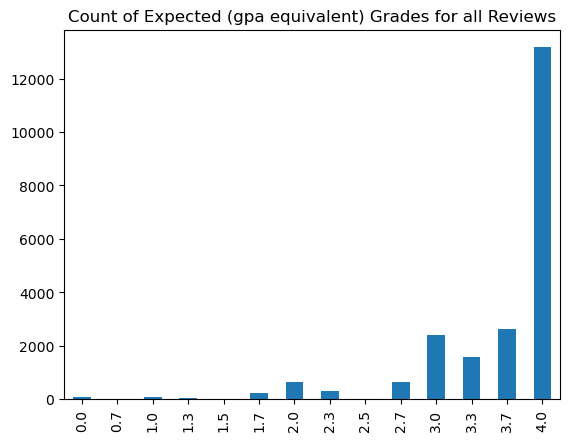

In [39]:
df['gpa_grade'].value_counts().sort_index().plot(kind="bar", title="Count of Expected (gpa equivalent) Grades for all Reviews")

We can see in the above chart, that the students who expect that they will receive a good grade, make up the vast majority of all students who leave reviews.

<AxesSubplot:title={'center':'Count of Number of Stars Awarded for all Reviews'}>

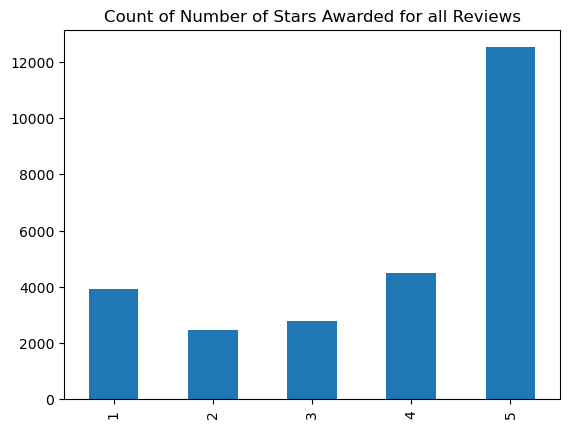

In [40]:
df.star_count.value_counts().sort_index().plot(kind="bar", title="Count of Number of Stars Awarded for all Reviews")

The chart above shows that most of the star ratings that students give to courses fall in the 5 star category, with a more even distribution for 0 to 4 stars.

<AxesSubplot:title={'center':'Total reviews over time'}, xlabel='year'>

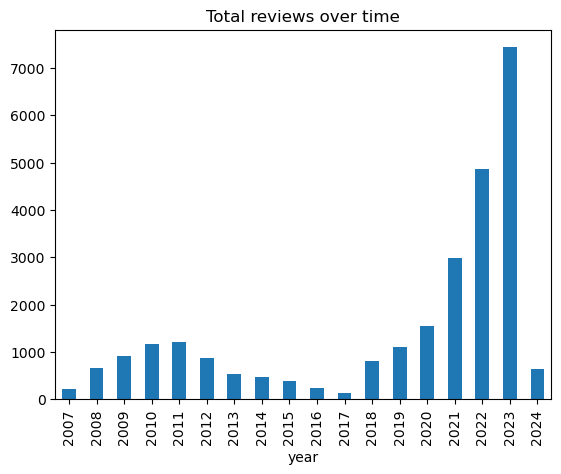

In [41]:
df.groupby('year').size().plot(kind="bar", title="Total reviews over time")

The chart above shows how the annual number of planetterp reviews has continuously, and significantly increased starting in 2021.

<AxesSubplot:title={'center':'Difference in Review Ratings from groupings of Students separated by their expected (GPA converted) grade level.'}>

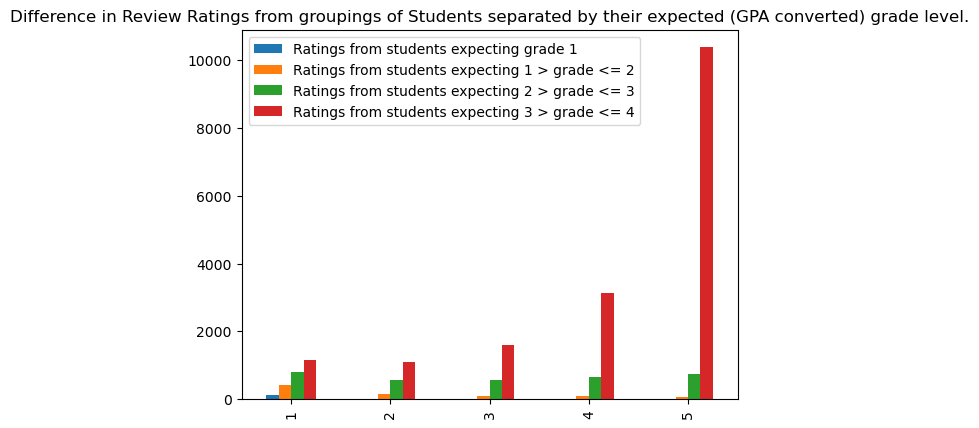

In [42]:
ratings_from_grade_earners_lte_1 = pd.Series(df[df["gpa_grade"] <= 1]["star_count"].value_counts().sort_index(),name="Ratings from students expecting grade 1")
ratings_from_grade_earners_gt_1_lte_2 = pd.Series(df[(df["gpa_grade"] > 1) & (df["gpa_grade"] <= 2)]["star_count"].value_counts().sort_index(),name="Ratings from students expecting 1 > grade <= 2")
ratings_from_grade_earners_gt_2_lte_3 = pd.Series(df[(df["gpa_grade"] > 2) & (df["gpa_grade"] <= 3)]["star_count"].value_counts().sort_index(),name="Ratings from students expecting 2 > grade <= 3")
ratings_from_grade_earners_gt_3_lte_4 = pd.Series(df[(df["gpa_grade"] > 3) & (df["gpa_grade"] <= 4)]["star_count"].value_counts().sort_index(),name="Ratings from students expecting 3 > grade <= 4")

crosstab_four_groups = pd.concat([
    ratings_from_grade_earners_lte_1,
    ratings_from_grade_earners_gt_1_lte_2,
    ratings_from_grade_earners_gt_2_lte_3,
    ratings_from_grade_earners_gt_3_lte_4
], axis=1)
crosstab_four_groups.plot(kind="bar", title="Difference in Review Ratings from groupings of Students separated by their expected (GPA converted) grade level.")

For the chart above, we have grouped reviewers into four groups based on their expected (GPA converted) grade. This chart indicates that the students expecting higher grades overwhelmingly are giving courses higher ratings (5 and 4 star ratings).


Out of curiosity, let's see the five most reviewed departments by year

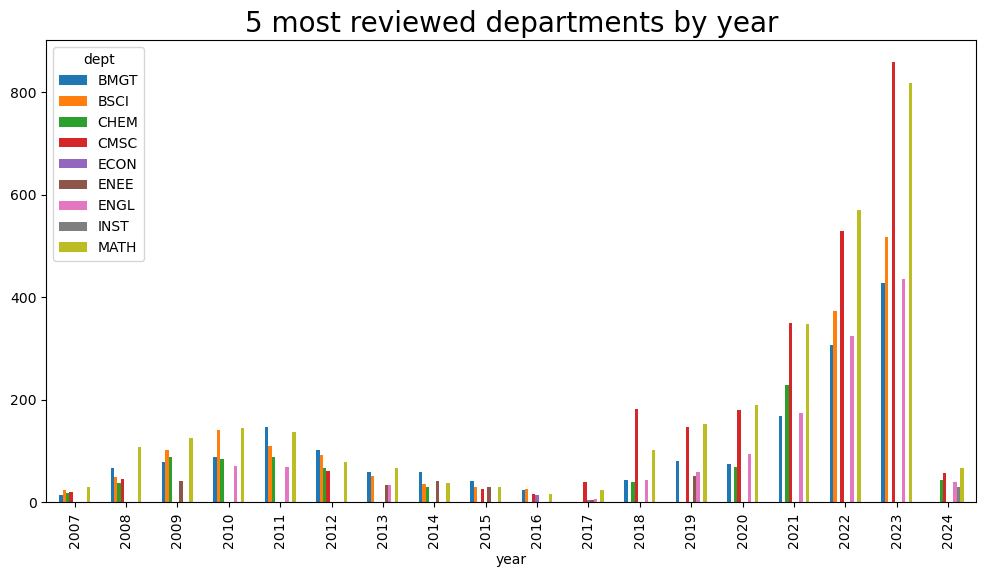

In [43]:
# 5 most reviewed departments by year
num_ratings_per_year_per_dept = df.groupby(["year"])["dept"].value_counts()
five_most_rated_depts_by_year = num_ratings_per_year_per_dept.groupby(level=0, group_keys=False).nlargest(5)

ax = five_most_rated_depts_by_year.reset_index(name="count")\
    .pivot_table(values="count", index="year", columns="dept")\
    .plot(
        kind="bar",
        figsize=(12, 6),
        title="5 most reviewed departments by year",
        width=0.6
    )

ax.title.set_size(20)

Seeing the rise in the popularity of the CMSC department we were curious to explore some CS department specific trends within our dataset. To achieve this purpose we are instantiating a new dataframe that will be used in trend depiction as well as for the purpose of analysis

In [44]:
df_cmsc = df[df['dept'] == 'CMSC']

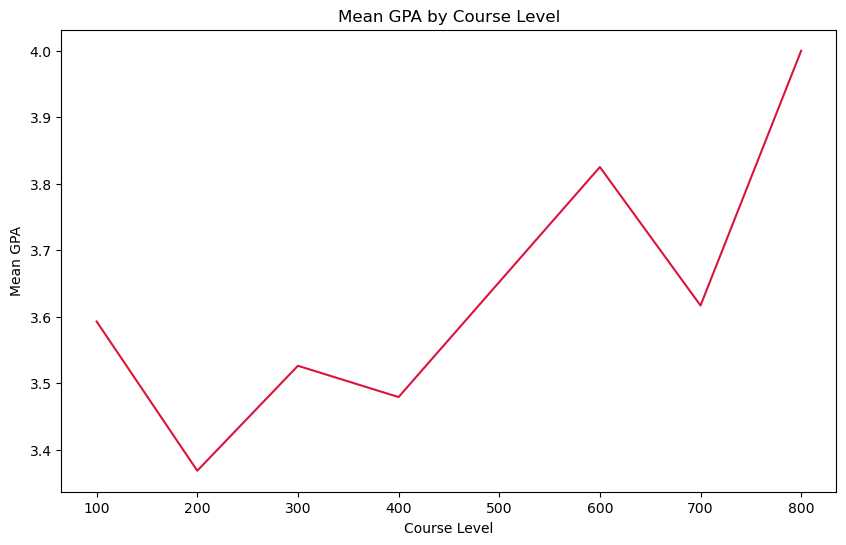

In [45]:
mean_gpa_by_level = df_cmsc.groupby('level')['gpa_grade'].mean()

plt.figure(figsize=(10, 6))
mean_gpa_by_level.plot(kind='line', color='crimson')
plt.title('Mean GPA by Course Level')
plt.xlabel('Course Level')
plt.ylabel('Mean GPA')
plt.xticks(rotation=0)
plt.show()

It is interesting to see how there are sharp falls and rise in the visualization above. This may be occuring either due to the presence of an outlier or potentially insufficient data records.

We can try and determine the reason behind this next!

In [46]:
df_cmsc['level'].value_counts().sort_index(level='level')

100    678
200    641
300    567
400    786
600      4
700     14
800      5
Name: level, dtype: int64

Our hunch behind the sharp rise and falls wihtin our line graph was correct! As we can clearly see there's a huge difference in the number of field rows for the 600,700, and 800 level courses in the CMSC department.

<Figure size 1200x600 with 0 Axes>

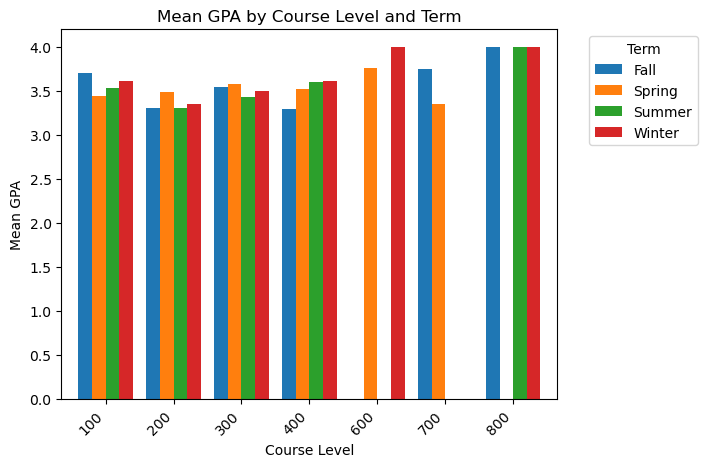

In [47]:
pivot_table = df_cmsc.pivot_table(values='gpa_grade', index='level', columns='term', aggfunc='mean')

plt.figure(figsize=(12, 6))
pivot_table.plot(kind='bar', width=0.8)
plt.title('Mean GPA by Course Level and Term')
plt.xlabel('Course Level')
plt.ylabel('Mean GPA')
plt.legend(title='Term', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.show()

The above chart highlights the GPA trends across different levels of CS courses in every term. It is interesting to see how the levels are surprisingly stable and more or less similar across each term

<AxesSubplot:title={'center':'Mean Expected Grade and Rating over time'}, xlabel='year'>

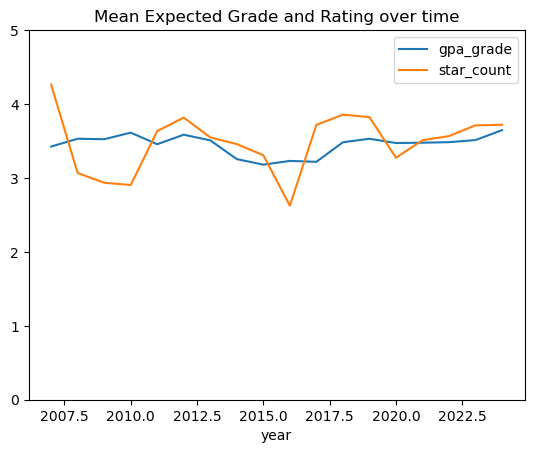

In [48]:
df_cmsc.groupby('year')[['gpa_grade','star_count']].mean().plot( title="Mean Expected Grade and Rating over time", ylim=[0,5])

The reviewers' expected grades and course ratings appear relatively steady over time.

### Hypothesis Test 1

#### Question:
Is difference in ratings from higher scoring students and less high scoring students, hinted at in the chart above, also reflected in the results of a chi-squared test?

A grade of an A or A- translate to a grade score of >= 3.7, so we will segment reviewers into two groups that fall on either side of the A- threshold.

In [49]:
greater_than_eq_3pt7 = pd.Series(df[df["gpa_grade"] >= 3.7]["star_count"].value_counts().sort_index(),name="Ratings from Students Expecting As")
less_than_3pt7 = pd.Series(df[df["gpa_grade"] < 3.7]["star_count"].value_counts().sort_index(),name="Ratings from Students Expecting less than As")

crosstab = pd.concat([greater_than_eq_3pt7,less_than_3pt7], axis=1)
crosstab

,Ratings from Students Expecting As,Ratings from Students Expecting less than As
1,909,1605
2,885,983
3,1360,923
4,2790,1126
5,9846,1352


<AxesSubplot:title={'center':'Difference in Review Ratings between: \nStudents expecting an A, and Students Expecting less than an A'}>

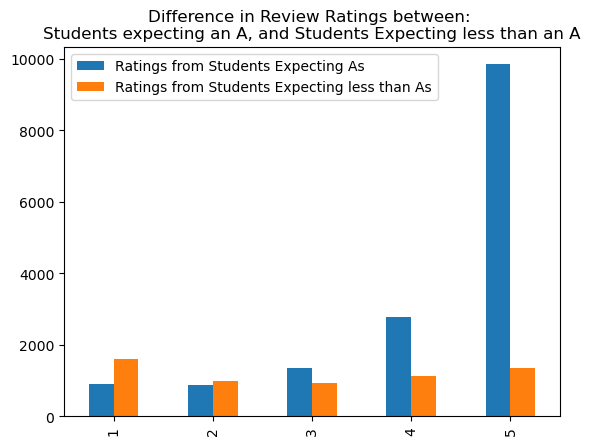

In [50]:
crosstab.plot(kind="bar", title="Difference in Review Ratings between: \nStudents expecting an A, and Students Expecting less than an A")

The difference in the distribution of star ratings is visually even more stark with just two groups of reviewers.

Null and alternative hypotheses:<br>
**H0: the distribution of course ratings (star count) is the same for the groups of:**
- students who are expecting an A- or higher
- students who are expecting less than an A-

**HA: the distribution of course ratings (star_count) is different for the two groups.**
##### Assume alpha of .05

In [57]:
stats.chi2_contingency(crosstab)

(3787.9709815243573,
 0.0,
 4,
 array([[1822.67597227,  691.32402773],
        [1354.31929841,  513.68070159],
        [1655.19858579,  627.80141421],
        [2839.1404564 , 1076.8595436 ],
        [8118.66568713, 3079.33431287]]))

#### Result:
Our p-value from the chi-squared test is near 0 and less than our alpha, therefore, we reject the null hypothesis.
The data indicate a statistically significant difference in the rating distributions between the two groups.

### Hypothesis Test 2

#### Question:

Is there a significant difference in mean GPA across different levels of CS courses and different years?


Taking into consideration the rise in the popularity of the CMSC department and trends the null and alternative hypothesis were determined to be:

1. Null Hypothesis: There is no significant difference in mean GPA across different levels of CS courses and different years.

2. Alternative Hypothesis: There is a significant difference in mean GPA across different levels of CS courses and different years.


Since there are more than 2 columns involved here it would be best for us to use ANOVA test and the level of significance being assumed for this test analysis is 0.05


It is necessary for the calculation of our p-value that the column under consideration has no duplicate values or records with null values within and so for the purpose of the experiment we won't be considering all such row fields.

In [58]:
df_cmsc_copy = df_cmsc.dropna(subset=['gpa_grade'])
df_cmsc_copy.drop_duplicates(inplace=True)
df_cmsc = df_cmsc_copy

Performing ANOVA analysis

In [59]:
new = ols('gpa_category ~ C(level) * C(year)', data=df_cmsc).fit()
an =  sm.stats.anova_lm(new, typ=2)
an

/Users/ShreenidhiAyinala/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 6, but rank is 5
  warnings.warn('covariance of constraints does not have full '
/Users/ShreenidhiAyinala/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 17, but rank is 14
  warnings.warn('covariance of constraints does not have full '
/Users/ShreenidhiAyinala/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:1871: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 102, but rank is 58
  warnings.warn('covariance of constraints does not have full '


,sum_sq,df,F,PR(>F)
C(level),14.293497,6.0,5.610144,0.000038
C(year),9.629165,17.0,1.333910,0.178955
C(level):C(year),58.066912,102.0,1.340650,0.045516
Residual,890.029718,2096.0,NaN,NaN


#### Result:

Since on performing ANOVA analysis we notice that our p-value is level than the level of significance i.e. 0.05 we will be rejecting our null hypothesis.

Thus, we can conclude that there is a significant difference in mean GPA across different levels of CS courses with the passage of time

<Figure size 1200x600 with 0 Axes>

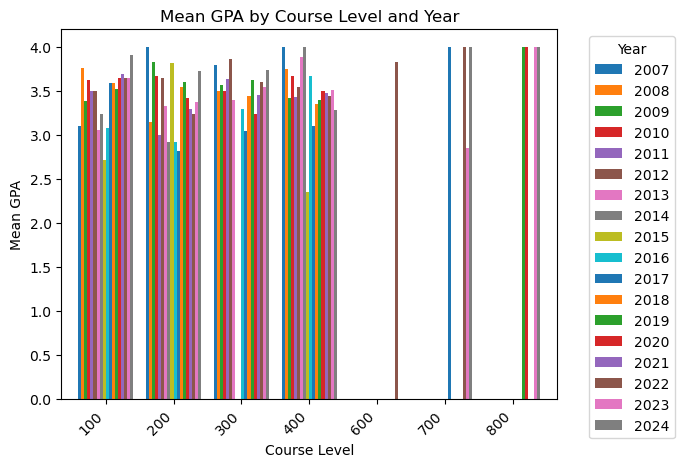

In [60]:
mean_gpa_by_level_year = df_cmsc.groupby(['level', 'year'])['gpa_grade'].mean()
mean_gpa_by_level_year = mean_gpa_by_level_year.unstack()

plt.figure(figsize=(12, 6))
mean_gpa_by_level_year.plot(kind='bar', width=0.8)
plt.title('Mean GPA by Course Level and Year')
plt.xlabel('Course Level')
plt.ylabel('Mean GPA')
plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.show()

The chart depicts the variations in the mean GPA amongst the different CMSC department course levels with the passage of time. It may be necessary for us to perform a POST HOC analysis here since it is clearly visible from the visualization and previous findings that the data is scarce for courses starting level 600 which may be potentially affecting our results.

### Hypothesis Test 3:

#### Question:
Is there a difference between the mean number of stars between anonymous versus non-anonymous users?


The null and alternate hypotheses are as follows:<br>
**H0:** The average star count is the same for anonymous and non-anonymous reviewers. <br>
**Ha:** The average star count is not the same for anonymous and non-anonymous reviewers.

_Assume the level of significance is 0.05._

Since we are testing the difference of the true average star count between two populations, it makes the most sense to utilize a two sample t-test.

In [61]:
anonymous_scores = df[df['reviewer_name'] == 'Anonymous']['star_count']
non_anonymous_scores = df[df['reviewer_name'] != 'Anonymous']['star_count']

t_stat, p_value = stats.ttest_ind(anonymous_scores, non_anonymous_scores)

print(f"t-statistic: {t_stat}")
print(f"p-value: {p_value}")

t-statistic: -10.744572153398497
p-value: 7.1533601785363e-27


#### Result:

We reject the null hypothesis because the p-value of 7.15e-27 is less than the level of significance 0.05. We can conclude that there is a difference between the mean star count of anonymous and non-anonymous reviewers.

The negative ttest that indicates that the anonymous_scores has a lower mean than the non_anonymous scores, indicating that the average star count is higher for non_anonymous_scores.

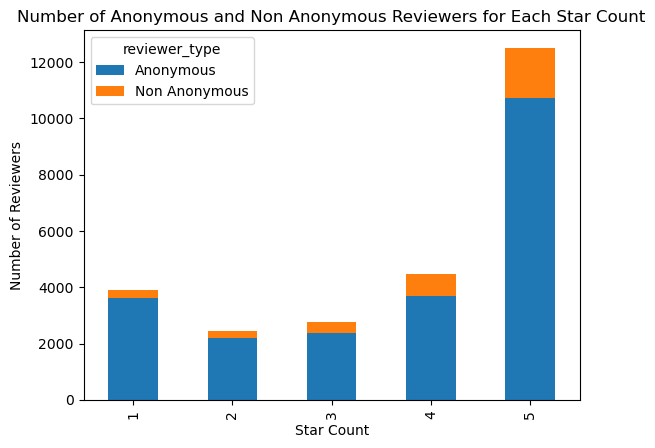

In [56]:
df['reviewer_type'] = df['reviewer_name'].apply(lambda x: 'Anonymous' if x == 'Anonymous' else 'Non Anonymous')
df.groupby(['star_count', 'reviewer_type']).size().unstack().plot(kind='bar', stacked=True)
plt.title('Number of Anonymous and Non Anonymous Reviewers for Each Star Count')
plt.xlabel('Star Count')
plt.ylabel('Number of Reviewers')
plt.show()

This bar graph represents the distribution of star ratings given by anonymous and non-anonymous reviewers. It’s clear that both types of reviewers tend to give higher star counts, with a significant spike at the 5-star rating. This data could be useful for understanding the behavior of different types of reviewers and their rating patterns.